In [38]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
import tensorflow
#Set random value
randomval = 1
#Set random seeds
np.random.seed(randomval)
tensorflow.random.set_seed(randomval)


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
     n_vars = 1 if type(data) is list else data.shape[1]
     df = DataFrame(data)
     cols, names = list(), list()
     # input sequence (t-n, ... t-1)
     for i in range(n_in, 0, -1):
         cols.append(df.shift(i))
     names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
     # forecast sequence (t, t+1, ... t+n)
     for i in range(0, n_out):
         cols.append(df.shift(-i))
     if i == 0:
         names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
     else:
         names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
     # put it all together
     agg = concat(cols, axis=1)
     agg.columns = names
     # drop rows with NaN values
     if dropnan:
         agg.dropna(inplace=True)
     return agg

In [24]:
# check data
checkdata = read_csv('raw.csv')
print(checkdata)

          No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd     Iws  \
0          1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW    1.79   
1          2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW    4.92   
2          3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW    6.71   
3          4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW    9.84   
4          5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW   12.97   
...      ...   ...    ...  ...   ...    ...   ...   ...     ...  ...     ...   
43819  43820  2014     12   31    19    8.0   -23  -2.0  1034.0   NW  231.97   
43820  43821  2014     12   31    20   10.0   -22  -3.0  1034.0   NW  237.78   
43821  43822  2014     12   31    21   10.0   -22  -3.0  1034.0   NW  242.70   
43822  43823  2014     12   31    22    8.0   -22  -4.0  1034.0   NW  246.72   
43823  43824  2014     12   31    23   12.0   -21  -3.0  1034.0   NW  249.85   

       Is  Ir  
0       0   0  
1      

In [25]:
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [26]:

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction, changes the label to something usefull, direction to value
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features using max min method
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head(5))


       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2       0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3       0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4       0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5       0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   
...          ...        ...        ...        ...        ...        ...   
43795   0.010060   0.264706   0.278689   0.763638   0.333333   0.385730   
43796   0.008048   0.250000   0.278689   0.781818   0.333333   0.395659   
43797   0.010060   0.264706   0.262295   0.781818   0.333333   0.405588   
43798   0.010060   0.264706   0.262295   0.781818   0.333333   0.413996   
43799   0.008048   0.264706   0.245902   0.781818   0.333333   0.420866   

       var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1       0.000000  

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)
Epoch 1/50
122/122 - 2s - loss: 0.0636 - val_loss: 0.0521 - 2s/epoch - 17ms/step
Epoch 2/50
122/122 - 0s - loss: 0.0468 - val_loss: 0.0523 - 451ms/epoch - 4ms/step
Epoch 3/50
122/122 - 0s - loss: 0.0286 - val_loss: 0.0444 - 428ms/epoch - 4ms/step
Epoch 4/50
122/122 - 0s - loss: 0.0186 - val_loss: 0.0395 - 484ms/epoch - 4ms/step
Epoch 5/50
122/122 - 0s - loss: 0.0167 - val_loss: 0.0294 - 457ms/epoch - 4ms/step
Epoch 6/50
122/122 - 0s - loss: 0.0156 - val_loss: 0.0212 - 420ms/epoch - 3ms/step
Epoch 7/50
122/122 - 0s - loss: 0.0149 - val_loss: 0.0179 - 400ms/epoch - 3ms/step
Epoch 8/50
122/122 - 0s - loss: 0.0148 - val_loss: 0.0166 - 400ms/epoch - 3ms/step
Epoch 9/50
122/122 - 0s - loss: 0.0147 - val_loss: 0.0159 - 411ms/epoch - 3ms/step
Epoch 10/50
122/122 - 0s - loss: 0.0149 - val_loss: 0.0155 - 419ms/epoch - 3ms/step
Epoch 11/50
122/122 - 0s - loss: 0.0147 - val_loss: 0.0150 - 406ms/epoch - 3ms/step
Epoch 12/50
122/122 - 0s - loss: 0.0147 - v

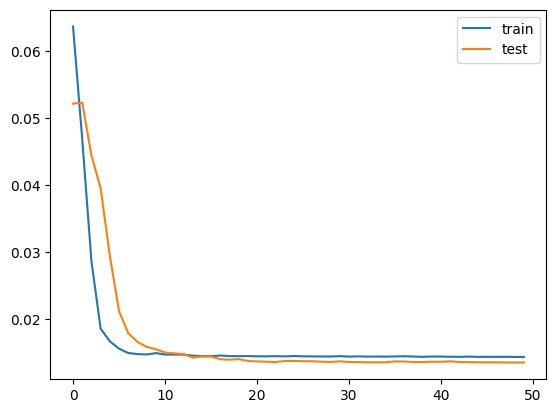

In [27]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [29]:
# make a prediction
yhat = model.predict(test_X)
print(yhat)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


InvalidArgumentError: Graph execution error:

transpose expects a vector of size 2. But input(1) is a vector of size 3
	 [[{{node transpose}}]]
	 [[sequential_3/lstm_3/PartitionedCall]] [Op:__inference_predict_function_422100]

In [108]:
################# GSL Attempt ###############
# load dataset
dataset = read_csv('GSL_Density_DataSet.csv', header=0, index_col=0)
values = dataset.values

values = values.astype('float32')
# normalize features using max min method
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict, none because we want to predict all cell velocities
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head(5))


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0   0.501520   0.507791   0.497382   0.496672   0.566256   
2        0.0   0.511651   0.510541   0.499127   0.489185   0.559322   
3        0.0   0.502533   0.513291   0.491274   0.490849   0.558552   
4        0.0   0.497467   0.504125   0.493892   0.494176   0.544684   
5        0.0   0.518744   0.515124   0.493019   0.495840   0.560092   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...   var2(t)   var3(t)  \
1   0.646368   0.720218   0.769888    0.781167  ...  0.511651  0.510541   
2   0.642700   0.719537   0.771203    0.782493  ...  0.502533  0.513291   
3   0.643434   0.733152   0.777120    0.782493  ...  0.497467  0.504125   
4   0.640499   0.721579   0.763314    0.774536  ...  0.518744  0.515124   
5   0.648569   0.727706   0.767916    0.777188  ...  0.518744  0.520623   

    var4(t)   var5(t)   var6(t)   var7(t)   var8(t)   var9(t)  var10(t)  \
1  0.499127  0.489185  0.559322  0.642700  0.71

In [109]:
# split into train and test sets
values = reframed.values
n_train_hours = int(len(values)*0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-11], train[:, -11:]
test_X, test_y = test[:, :-11], test[:,-11:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(19720, 1, 11) (19720, 11) (4931, 1, 11) (4931, 11)


In [110]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(11))
model.compile(loss='mae', optimizer='adam')

Epoch 1/50
274/274 - 4s - loss: 0.0868 - val_loss: 0.0147 - 4s/epoch - 16ms/step
Epoch 2/50
274/274 - 1s - loss: 0.0189 - val_loss: 0.0141 - 925ms/epoch - 3ms/step
Epoch 3/50
274/274 - 1s - loss: 0.0181 - val_loss: 0.0133 - 931ms/epoch - 3ms/step
Epoch 4/50
274/274 - 1s - loss: 0.0174 - val_loss: 0.0126 - 907ms/epoch - 3ms/step
Epoch 5/50
274/274 - 1s - loss: 0.0167 - val_loss: 0.0118 - 919ms/epoch - 3ms/step
Epoch 6/50
274/274 - 1s - loss: 0.0159 - val_loss: 0.0115 - 923ms/epoch - 3ms/step
Epoch 7/50
274/274 - 1s - loss: 0.0152 - val_loss: 0.0110 - 951ms/epoch - 3ms/step
Epoch 8/50
274/274 - 1s - loss: 0.0146 - val_loss: 0.0106 - 922ms/epoch - 3ms/step
Epoch 9/50
274/274 - 1s - loss: 0.0143 - val_loss: 0.0104 - 910ms/epoch - 3ms/step
Epoch 10/50
274/274 - 1s - loss: 0.0140 - val_loss: 0.0102 - 1s/epoch - 4ms/step
Epoch 11/50
274/274 - 1s - loss: 0.0138 - val_loss: 0.0100 - 912ms/epoch - 3ms/step
Epoch 12/50
274/274 - 1s - loss: 0.0137 - val_loss: 0.0101 - 1s/epoch - 4ms/step
Epoch 13/

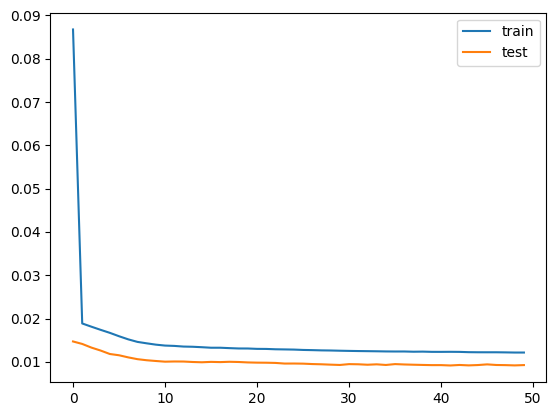

In [111]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [112]:
# make a prediction, it works but now it is getting the performance out of the information, so I will call it for the night
yhat = model.predict(test_X)
print(yhat)
print(test_X.shape)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X.shape)
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 11))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


155/155 [==============================] - 1s 2ms/step
[[-0.00215056  0.47082922  0.45835185 ...  0.7558236   0.7782259
   0.7766818 ]
 [-0.00220672  0.46170786  0.44821253 ...  0.7545517   0.7774894
   0.77533185]
 [-0.00200453  0.4700591   0.4568413  ...  0.75758624  0.7769195
   0.77552265]
 ...
 [-0.0024323   0.5302298   0.516145   ...  0.81965446  0.8180541
   0.8044899 ]
 [-0.0024371   0.52527106  0.51127553 ...  0.81452125  0.81641674
   0.8045912 ]
 [-0.00237055  0.52528495  0.51113856 ...  0.81359065  0.80970883
   0.7984672 ]]
(4931, 1, 11)
(4931, 11)
(4931, 21)


ValueError: operands could not be broadcast together with shapes (4931,21) (11,) (4931,21) 